# <font style="color:blue">Project 2: Kaggle Competition - Classification</font>

#### Maximum Points: 100

<div>
    <table>
        <tr><td><h3>Sr. no.</h3></td> <td><h3>Section</h3></td> <td><h3>Points</h3></td> </tr>
        <tr><td><h3>1</h3></td> <td><h3>Data Loader</h3></td> <td><h3>10</h3></td> </tr>
        <tr><td><h3>2</h3></td> <td><h3>Configuration</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>3</h3></td> <td><h3>Evaluation Metric</h3></td> <td><h3>10</h3></td> </tr>
        <tr><td><h3>4</h3></td> <td><h3>Train and Validation</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>5</h3></td> <td><h3>Model</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>6</h3></td> <td><h3>Utils</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>7</h3></td> <td><h3>Experiment</h3></td><td><h3>5</h3></td> </tr>
        <tr><td><h3>8</h3></td> <td><h3>TensorBoard Log</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>9</h3></td> <td><h3>Kaggle Profile Link</h3></td> <td><h3>50</h3></td> </tr>
    </table>
</div>


## <font style="color:green">1. Data Loader [10 Points]</font>

In this section, you have to write a class or methods, which will be used to get training and validation data loader.

You need to write a custom dataset class to load data.

**Note; There is   no separate validation data. , You will thus have to create your own validation set, by dividing the train data into train and validation data. Usually, we do 80:20 ratio for train and validation, respectively.**


For example:

```python
class KenyanFood13Dataset(Dataset):
    """
    
    """
    
    def __init__(self, *args):
    ....
    ...
    
    def __getitem__(self, idx):
    ...
    ...
    
    
```

```
def get_data(args1, *agrs):
    ....
    ....
    return train_loader, test_loader
```

In [1]:
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torchvision.transforms import functional as F
from torchvision import datasets, transforms


import matplotlib.pyplot as plt

import os
import numpy as np
import pandas as pd
import time

from typing import Iterable
# from dataclasses import dataclass

from PIL import Image

# %matplotlib notebook
# %load_ext autoreload
# %autoreload 2

from operator import itemgetter

from torch.optim.lr_scheduler import MultiStepLR

from trainer import Trainer, hooks, configuration
from trainer.utils import setup_system, patch_configs
from trainer.metrics import AccuracyEstimator
from trainer.tensorboard_visualizer import TensorBoardVisualizer

/home/shreyas/virtualenvs/pytorch_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-02-16 09:54:12.476361: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739728452.489703   30805 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739728452.493886   30805 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-16 09:54:12.507798: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance

In [3]:
class KenyanFood13Dataset(Dataset):
    """
    This custom dataset class takes root directory and train flag, 
    and returns dataset training dataset if train flag is true 
    else it returns validation dataset.
    """
    
    def __init__(self, data_root, train=True, image_shape=None, transform=None):
        
        """
        init method of the class.
        
         Parameters:
         
         data_root (string): path of root directory.
         
         train (boolean): True for training dataset and False for test dataset.
         
         image_shape (int or tuple or list): [optional] int or tuple or list. Defaut is None. 
                                             If it is not None image will resize to the given shape.
                                 
         transform (method): method that will take PIL image and transform it.
         
        """
        
        # get label to species mapping
        label_csv_path = os.path.join(data_root, 'train.csv')
        self.data_df = pd.read_csv(label_csv_path, delimiter=' *, *', engine='python')
        self.classes = self.data_df.iloc[:, 1].unique()
        self.num_classes = len(self.classes)
        self.image_ids = self.data_df.iloc[:, 0]

        self.class_given_label = {image_id : image_class for image_id, image_class in enumerate(self.classes)}
        self.label_given_class = {image_class : image_id for image_id, image_class in enumerate(self.classes)}
        
        # set image_resize attribute
        if image_shape is not None:
            if isinstance(image_shape, int):
                self.image_shape = (image_shape, image_shape)
            
            elif isinstance(image_shape, tuple) or isinstance(image_shape, list):
                assert len(image_shape) == 1 or len(image_shape) == 2, 'Invalid image_shape tuple size'
                if len(image_shape) == 1:
                    self.image_shape = (image_shape[0], image_shape[0])
                else:
                    self.image_shape = image_shape
            else:
                raise NotImplementedError 
                
        else:
            self.image_shape = image_shape
            
        # set transform attribute
        self.transform = transform

        # initialize the data dictionary
        self.data_dict = {
            'image_path': [],
            'label': []
        }
        img_dir = os.path.join(data_root, 'images', 'images')

        # print("self.data_df", type(self.data_df))
        for data in self.data_df.iterrows():
            image_id = str(data[1]['id']) + '.jpg'
            image_path = os.path.join(img_dir, image_id)
            image_class = data[1]['class']
            label = self.label_given_class[image_class]
            self.data_dict['image_path'].append(image_path)
            self.data_dict['label'].append(label)

    
    def __len__(self):
        """
        return length of the dataset
        """
        return len(self.data_dict['label'])
    
    
    def __getitem__(self, idx):
        """
        For given index, return images with resize and preprocessing.
        """
        
        image = Image.open(self.data_dict['image_path'][idx]).convert("RGB")
        
        if self.image_shape is not None:
            image = F.resize(image, self.image_shape)
            
        if self.transform is not None:
            image = self.transform(image)
            
        target = self.data_dict['label'][idx]
        
        return image, target            
                
        
    def class_name(self, label):
        """
        class label to common name mapping
        """
        return self.class_given_label[label]

Length of the dataset: 6536
Label: 4, class name: sukumawiki


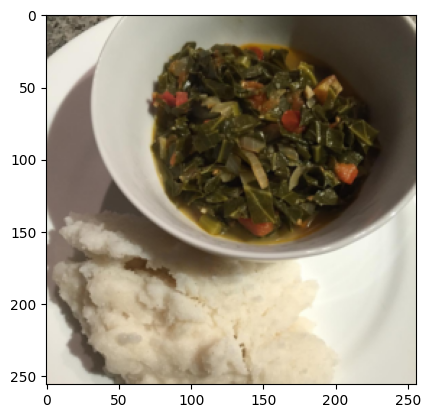

In [4]:
# data root directory
# data_root = '../resource/lib/publicdata/images/10-monkey-species'
data_root = '../../../data/Week7_project2_classification/KenyanFood13Dataset'

dataset =  KenyanFood13Dataset(data_root, train=True, image_shape=256)

print('Length of the dataset: {}'.format(len(dataset)))

img, trgt = dataset[300]

print('Label: {}, class name: {}'.format(trgt, dataset.class_name(trgt)))
plt.imshow(img)
plt.show()


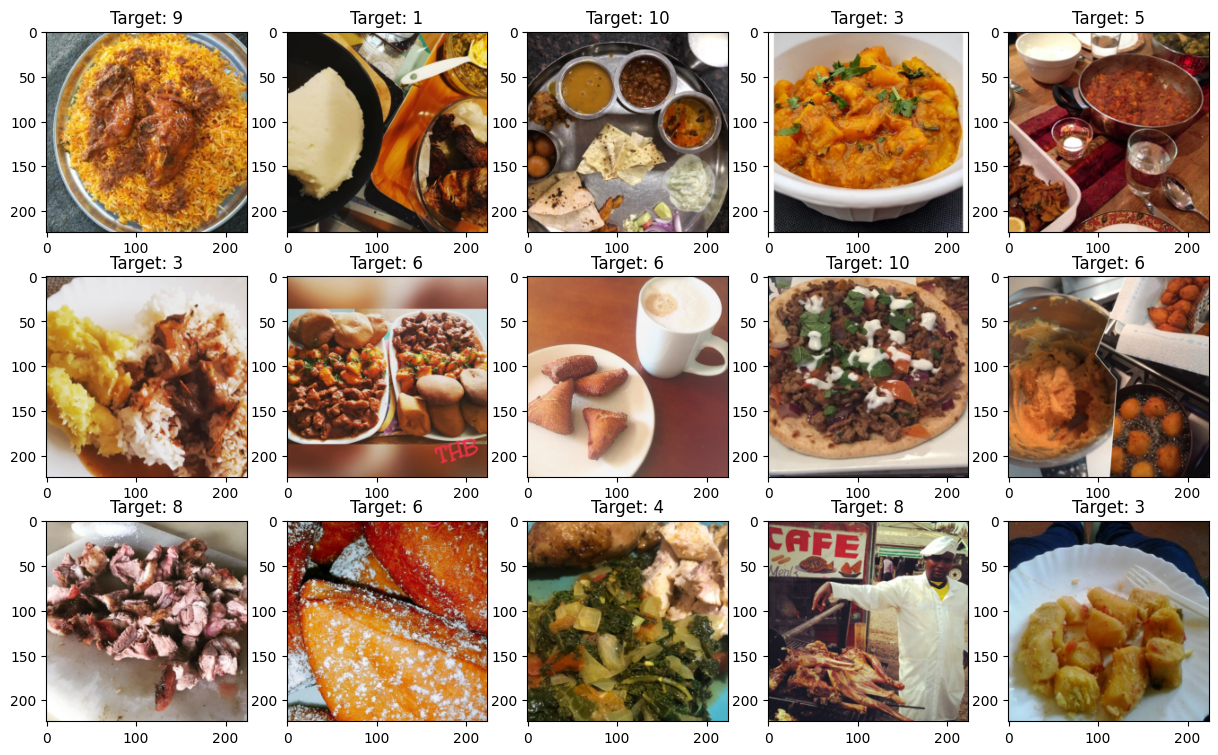

In [5]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()
    ])

dataset =  KenyanFood13Dataset(data_root, train=False, image_shape=None, transform=preprocess)


train_size = int(0.8 * len(dataset)) # 80% for training
validation_size = len(dataset) - train_size # 20% for validation

train_dataset, validation_dataset = random_split(dataset, [train_size, validation_size])



# dataloader with dataset
test_loader = torch.utils.data.DataLoader(
        validation_dataset,
        batch_size=15,
        shuffle=True,
        num_workers=2
    )


# Plot few images
plt.rcParams["figure.figsize"] = (15, 9)
plt.figure
for images, labels in test_loader:
    for i in range(len(labels)):
        plt.subplot(3, 5, i+1)
        img = F.to_pil_image(images[i])
        plt.imshow(img)
        plt.gca().set_title('Target: {0}'.format(labels[i]))
    plt.show()
    break

In [6]:
def get_data(batch_size, data_root='data', num_workers=1):
    train_test_transforms = transforms.Compose([
        # Resize to 32X32
        transforms.Resize((32, 32)),
        # this re-scale image tensor values between 0-1. image_tensor /= 255
        transforms.ToTensor(),
        # subtract mean (0.1307) and divide by variance (0.3081).
        # This mean and variance is calculated on training data (verify yourself)
        transforms.Normalize((0.1307, ), (0.3081, ))
    ])
    
    dataset =  KenyanFood13Dataset(data_root, train=False, image_shape=None, transform=preprocess)
    train_size = int(0.8 * len(dataset)) # 80% for training
    test_size = len(dataset) - train_size # 20% for validation
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    # train dataloader
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers
    )

    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers
    )
    
    # # train dataloader
    # train_loader = torch.utils.data.DataLoader(
    #     datasets.MNIST(root=data_root, train=True, download=True, transform=train_test_transforms),
    #     batch_size=batch_size,
    #     shuffle=True,
    #     num_workers=num_workers
    # )

    # # test dataloader
    # test_loader = torch.utils.data.DataLoader(
    #     datasets.MNIST(root=data_root, train=False, download=True, transform=train_test_transforms),
    #     batch_size=batch_size,
    #     shuffle=False,
    #     num_workers=num_workers
    # )
    
    return train_loader, test_loader

## <font style="color:green">2. Configuration [5 Points]</font>

**Define your configuration here.**

For example:


```python
@dataclass
class TrainingConfiguration:
    '''
    Describes configuration of the training process
    '''
    batch_size: int = 10 
    epochs_count: int = 50  
    init_learning_rate: float = 0.1  # initial learning rate for lr scheduler
    log_interval: int = 5  
    test_interval: int = 1  
    data_root: str = "/kaggle/input/opencv-pytorch-classification-project-2/" 
    num_workers: int = 2  
    device: str = 'cuda'  
    
```

## <font style="color:green">3. Evaluation Metric [10 Points]</font>

**Define methods or classes that will be used in model evaluation. For example, accuracy, f1-score etc.**

## <font style="color:green">4. Train and Validation [5 Points]</font>


**Write the methods or classes to be used for training and validation.**

Develop the Interface for the Train Function

## <font style="color:green">5. Model [5 Points]</font>

**Define your model in this section.**

**You are allowed to use any pre-trained model.**

In [7]:
class LeNet5(nn.Module):
    def __init__(self):
        super().__init__()

        self._body = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
        )
        self._head = nn.Sequential(
            nn.Linear(in_features=16 * 5 * 5, out_features=120), nn.ReLU(inplace=True),
            nn.Linear(in_features=120, out_features=84), nn.ReLU(inplace=True),
            nn.Linear(in_features=84, out_features=10)
        )

    def forward(self, x):
        x = self._body(x)
        x = x.view(x.size()[0], -1)
        x = self._head(x)
        return x

## <font style="color:green">6. Utils [5 Points]</font>

**Define those methods or classes, which have  not been covered in the above sections.**

Main Function

In [8]:
def main(system_configuration=SystemConfiguration(), training_configuration=TrainingConfiguration()):
    # system configuration
    setup_system(system_configuration)
    
    # batch size
    batch_size_to_set = training_configuration.batch_size
    # num_workers
    num_workers_to_set = training_configuration.num_workers
    # epochs
    epoch_num_to_set = training_configuration.epochs_count
    
    # if GPU is available use training config, 
    # else lower batch_size, num_workers and epochs count
    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
        batch_size_to_set = 16
        num_workers_to_set = 2
        epoch_num_to_set = 5
        
    # data loader
    train_loader, test_loader = get_data(
        batch_size=batch_size_to_set,
        data_root=training_configuration.data_root,
        num_workers=num_workers_to_set
    )
    
    # Update training configuration
    training_configuration = TrainingConfiguration(
        device=device,
        epochs_count=epoch_num_to_set,
        batch_size=batch_size_to_set,
        num_workers=num_workers_to_set
    )
    
    # initiate model
    model = LeNet5()
    
    # send model to device (GPU/CPU)
    model.to(training_configuration.device)
    
    # optimizer
    optimizer = optim.SGD(
        model.parameters(),
        lr=training_configuration.learning_rate
    )
    
    best_loss = torch.tensor(np.inf)
    
    # epoch train/test loss
    epoch_train_loss = np.array([])
    epoch_test_loss = np.array([])
    
    # epoch train/test accuracy
    epoch_train_acc = np.array([])
    epoch_test_acc = np.array([])
    
    # training time measurement
    t_begin = time.time()
    for epoch in range(training_configuration.epochs_count):
        train_loss, train_acc = train(training_configuration, model, optimizer, train_loader, epoch)
        epoch_train_loss = np.append(epoch_train_loss, [train_loss])
        epoch_train_acc = np.append(epoch_train_acc, [train_acc])
    
        elapsed_time = time.time() - t_begin
        speed_epoch = elapsed_time / (epoch + 1)
        speed_batch = speed_epoch / len(train_loader)
        eta = speed_epoch * training_configuration.epochs_count - elapsed_time
        
        print("Elapsed {:.2f}s, {:.2f} s/epoch, {:.2f} s/batch, ets {:.2f}s".format(
            elapsed_time, speed_epoch, speed_batch, eta))
        
        if epoch % training_configuration.test_interval == 0:
            current_loss, current_accuracy = validate(training_configuration, model, test_loader)
        
        epoch_test_loss = np.append(epoch_test_loss, [current_loss])
        epoch_test_acc = np.append(epoch_test_acc, [current_accuracy])
        
        if current_loss < best_loss:
            best_loss = current_loss
        
        print("Total time: {:.2f}, Best Loss: {:.3f}".format(time.time() - t_begin, best_loss))
    
    return model, epoch_train_loss, epoch_train_acc, epoch_test_loss, epoch_test_acc

NameError: name 'SystemConfiguration' is not defined

## <font style="color:green">7. Experiment [5 Points]</font>

**Choose your optimizer and LR-scheduler and use the above methods and classes to train your model.**

In [ ]:
class Experiment:
    def __init__(
        self,
        system_config: configuration.SystemConfig = configuration.SystemConfig(),
        dataset_config: configuration.DatasetConfig = configuration.DatasetConfig(),
        dataloader_config: configuration.DataloaderConfig = configuration.DataloaderConfig(),
        optimizer_config: configuration.OptimizerConfig = configuration.OptimizerConfig()
    ):
        self.loader_train, self.loader_test = get_data(
            batch_size=dataloader_config.batch_size,
            num_workers=dataloader_config.num_workers,
            data_root=dataset_config.root_dir
        )
        
        setup_system(system_config)

        self.model = LeNet5()
        self.loss_fn = nn.CrossEntropyLoss()
        self.metric_fn = AccuracyEstimator(topk=(1, ))
        self.optimizer = optim.SGD(
            self.model.parameters(),
            lr=optimizer_config.learning_rate,
            weight_decay=optimizer_config.weight_decay,
            momentum=optimizer_config.momentum
        )
        self.lr_scheduler = MultiStepLR(
            self.optimizer, milestones=optimizer_config.lr_step_milestones, gamma=optimizer_config.lr_gamma
        )
        self.visualizer = TensorBoardVisualizer()

    def run(self, trainer_config: configuration.TrainerConfig) -> dict:

        device = torch.device(trainer_config.device)
        self.model = self.model.to(device)
        self.loss_fn = self.loss_fn.to(device)

        model_trainer = Trainer(
            model=self.model,
            loader_train=self.loader_train,
            loader_test=self.loader_test,
            loss_fn=self.loss_fn,
            metric_fn=self.metric_fn,
            optimizer=self.optimizer,
            lr_scheduler=self.lr_scheduler,
            device=device,
            data_getter=itemgetter(0),
            target_getter=itemgetter(1),
            stage_progress=trainer_config.progress_bar,
            get_key_metric=itemgetter("top1"),
            visualizer=self.visualizer,
            model_saving_frequency=trainer_config.model_saving_frequency,
            save_dir=trainer_config.model_dir
        )

        model_trainer.register_hook("end_epoch", hooks.end_epoch_hook_classification)
        self.metrics = model_trainer.fit(trainer_config.epoch_num)
        return self.metrics

In [ ]:
def main():
    '''Run the experiment
    '''
    # patch configs depending on cuda availability
    dataloader_config, trainer_config = patch_configs(epoch_num_to_set=1)#5)
    # dataset_config = configuration.DatasetConfig(root_dir="data")
    dataset_config = configuration.DatasetConfig(root_dir="../../../data/Week7_project2_classification/KenyanFood13Dataset")
    experiment = Experiment(dataset_config=dataset_config, dataloader_config=dataloader_config)
    results = experiment.run(trainer_config)

    return results

In [ ]:
if __name__ == '__main__':
    main()

## <font style="color:green">8. TensorBoard Log [5 Points]</font>

**Share your TensorBoard scalars logs here You can also share (not mandatory) your GitHub link, if you have pushed this project in GitHub.**


<font style="color:red">Note:</font> In light of the recent shutdown of tensorboard.dev, we have updated the submission requirements for your project. Instead of sharing a tensorboard.dev link, you are now required to upload your generated TensorBoard event files directly onto the lab. As an alternative, you may also include a screenshot of your TensorBoard output within your Jupyter notebook. This adjustment ensures that your data visualization and model training efforts are thoroughly documented and accessible for evaluation.

## <font style="color:green">9. Kaggle Profile Link [50 Points]</font>

**Share your Kaggle profile link  with us here to score , points in  the competition.**

**For full points, you need a minimum accuracy of `75%` on the test data. If accuracy is less than `70%`, you gain  no points for this section.**


**Submit `submission.csv` (prediction for images in `test.csv`), in the `Submit Predictions` tab in Kaggle, to get evaluated for  this section.**